# Download dataset from kaggle

Install kaggle


In [5]:
!pip3 install -q kaggle

Mount the **gdrive**


In [33]:
# from google.colab import drive
# drive.mount('/content/gdrive')
models_drive_folder = "./models"

Colab requires the file to be placed in /.kaggle


In [3]:
!mkdir -p ~/.kaggle
!cp ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Take ownership of the kaggle.json file


Download the dataset


In [4]:
!kaggle datasets download -d grassknoted/asl-alphabet

100%|█████████████████████████████████████▉| 1.02G/1.03G [00:30<00:00, 34.0MB/s]
100%|██████████████████████████████████████| 1.03G/1.03G [00:30<00:00, 36.1MB/s]


In [5]:
import zipfile

FILENAME = "./asl-alphabet.zip"
with zipfile.ZipFile(FILENAME, "r") as f:
    f.extractall(".")

In [6]:
!ls asl_alphabet_train/asl_alphabet_train/

A/       E/       I/       M/       Q/       U/       Y/       space/
B/       F/       J/       N/       R/       V/       Z/
C/       G/       K/       O/       S/       W/       del/
D/       H/       L/       P/       T/       X/       nothing/


# Prep Pytorch


### Install


In [7]:
!pip install -q validators matplotlib
!pip install -q torch-summary
!pip install -q torchmetrics

In [1]:
from __future__ import division, print_function

import time
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, transforms

warnings.filterwarnings("ignore")
%matplotlib inline

plt.ion()  # interactive mode

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Cuda is available: {torch.cuda.is_available()}")
print(f"Using {device} for inference")

Cuda is available: True
Using cuda for inference


### Dataloaders


In [13]:
import os
import torch
from torch.utils.data import DataLoader

TRAIN_DATA_PATH = "./asl_alphabet_train/asl_alphabet_train"


def gen_dataloaders(normalize=True, add_transforms=[], batch_size=64, verbose=False):
    transformers = [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]

    if len(add_transforms):
        transformers.extend(add_transforms)

    if normalize:
        transformers.append(
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        )

    # The transformer is used here to reshape images to 224x224 and convert to tensor
    simple_transformer = transforms.Compose(transformers)

    data_dir = os.path.join(str(TRAIN_DATA_PATH))

    # ImageFolder is a generic data set where the images are arranged in sub-folders corresponding to classes
    dataset = datasets.ImageFolder(data_dir, simple_transformer)
    generator = torch.Generator().manual_seed(42)

    train_set, val_set, test_set = torch.utils.data.random_split(
        dataset, [0.8, 0.1, 0.1], generator
    )

    image_datasets = {"train": train_set, "val": val_set, "test": test_set}

    dataset_sizes = {x: len(image_datasets[x]) for x in image_datasets}

    # Combines a dataset and a sampler, and provides an iterable over the given dataset.
    dataloaders = {
        x: DataLoader(
            image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4
        )
        for x in image_datasets
    }

    class_names = dataset.classes
    if verbose:
        print(f"Using {batch_size} images per batch")
        print(f"Dataset sizes: {dataset_sizes}")
        print(f"Classes: {class_names}")
    return dataloaders, class_names, batch_size, dataset_sizes

In [3]:
norm_dataloaders, class_names, batch_size, dataset_sizes = gen_dataloaders()

In [10]:
import matplotlib.pyplot as plt


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Models


### Load resneXt model


In [6]:
def load_resnext50_model(verbose=False):
    model = torchvision.models.resnext50_32x4d(pretrained=True)

    model.eval().to(device)

    model_fc = torch.nn.Linear(model.fc.in_features, len(class_names), bias=True).to(
        device
    )

    model.fc = model_fc

    # By default, all weights are initialised with xaiver uniform

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total number of trainable parameters: {total_params}")
    if verbose:
        print(model)

    # Prevent grad for params for the model
    for param in model.parameters():
        param.requires_grad = False

    return model, model_fc


version = "adam"
model_name = f"resnext50_{version}"

print(f"Model name: {model_name}")
model, model_fc = load_resnext50_model()

Model name: resnext50_adam
Total number of trainable parameters: 23039325


### Load Mobilenet Model


In [4]:
def load_mobilenet_model(verbose=False):
    model = torchvision.models.mobilenet_v2(pretrained=True)

    model.eval().to(device)

    model_fc = torch.nn.Linear(
        model.classifier[1].in_features, len(class_names), bias=True
    ).to(device)

    model.classifier[1] = model_fc

    # By default, all weights are initialised with xaiver uniform

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    if verbose:
        print(f"Total number of trainable parameters: {total_params}")
        print(model)

    return model, model_fc


# Set model name here for rest of the code
model_name = "mobilenet_adam"
print(f"Model name: {model_name}")
model, model_fc = load_mobilenet_model(verbose=True)

Model name: mobilenet_adam
Total number of trainable parameters: 2261021
MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_si

# Transfer Learning


In [ ]:
# !wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

### Training method


In [17]:
from torchvision.models import ResNet, MobileNetV2
from tqdm import tqdm


def save_checkpoint(epoch, model: ResNet | MobileNetV2, optimizer, scheduler, filename):
    checkpoint = {
        "epoch": epoch,
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(model: ResNet | MobileNetV2, optimizer, scheduler, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    previous_epoch_num = checkpoint["epoch"]
    return model, optimizer, scheduler, previous_epoch_num


def train_model(
    model: ResNet | MobileNetV2,
    dataloaders: dict[str, DataLoader],
    criterion: nn.CrossEntropyLoss,
    optimizer: torch.optim.Adam | torch.optim.SGD,
    scheduler: lr_scheduler.StepLR,
    save_dir=".",
    num_epochs=25,
    previous_epochs=0,
):
    since = time.time()

    best_model_params_path = os.path.join(save_dir, "best_model_params.pt")
    history_path = os.path.join(save_dir, "model_history.pt")

    # Create save directory if it doesn't exist
    if save_dir != ".":
        Path(save_dir).mkdir(parents=True, exist_ok=True)

    best_acc = 0.0
    history = {
        "loss": [],
        "accuracy": [],
        "val_loss": [],
        "val_accuracy": [],
        "lr": [],
        "batch_size": batch_size,
    }
    for epoch in range(num_epochs):
        epoch_num = previous_epochs + epoch + 1
        print(f"Epoch {epoch_num}/{previous_epochs + num_epochs}")
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
                print(f"Learning rate: {scheduler.get_lr()}")
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == "val":
                history["val_loss"].append(epoch_loss)
                history["val_accuracy"].append(epoch_acc.item())
            elif phase == "train":
                history["loss"].append(epoch_loss)
                history["accuracy"].append(epoch_acc.item())
                history["lr"].append(scheduler.get_lr())

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                print(
                    f"Found new best accuracy! Saving best model to {best_model_params_path}..."
                )
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        # Save checkpoint and history after each epoch
        save_checkpoint(
            epoch_num,
            model,
            optimizer,
            scheduler,
            os.path.join(save_dir, f"epoch_{epoch_num}_checkpoint.pt"),
        )
        torch.save(history, history_path)

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best accuracy: {best_acc}")

    # Load best model weights
    model.load_state_dict(torch.load(best_model_params_path))

    return model, history

In [40]:
def get_last_model_params(
    model_name,
    model: ResNet | MobileNetV2,
    optimizer: torch.optim.Adam | torch.optim.SGD,
    scheduler: lr_scheduler.StepLR,
):
    # Find model param files
    try:
        model_dir_path = os.path.join(model_name)
        dir_paths = os.listdir(model_dir_path)
        model_params = [
            f
            for f in dir_paths
            if f.startswith("epoch") and f.endswith("_checkpoint.pt")
        ]

        if len(model_params) == 0:
            raise Exception()

        model_params.sort()

        # Load history
        history_path = os.path.join(model_dir_path, "model_history.pt")
        history = torch.load(history_path)

        # Print accuracy for each model param file
        epochs_dicts = [
            {"epoch": epoch + 1, **{key: history[key][epoch] for key in history}}
            for epoch in range(len(history["accuracy"]))
        ]

        print("Old epochs:")
        print("-" * 10)
        print()
        for epoch_dict in epochs_dicts:
            # Print "print" statements from train_model function
            print(f"Epoch {epoch_dict['epoch']}/{len(epochs_dicts)}")
            print("-" * 10)

            print(
                f"train Loss: {epoch_dict['loss']:.4f} Acc: {epoch_dict['accuracy']:.4f}"
            )
            print(
                f"val Loss: {epoch_dict['val_loss']:.4f} Acc: {epoch_dict['val_accuracy']:.4f}"
            )
            print()

        # Load model params from last model param file

        latest_model_params_path = os.path.join(model_dir_path, model_params[-1])

        model, optimizer, scheduler, previous_epoch_num = load_checkpoint(
            model,
            optimizer,
            scheduler,
            latest_model_params_path,
        )

        print("Model loaded: ", os.path.join(model_dir_path, model_params[-1]))
        print("Continue training ...")
        print()

        return model, optimizer, scheduler, previous_epoch_num
    except:
        print("No model checkpoints found" + "\n")
        return model, optimizer, scheduler, 0

### Training


In [42]:
continue_train = False
previous_epochs = 0

# Params for the model
for param in model.parameters():
    param.requires_grad = False

# model.fc.requires_grad = True
for param in model_fc.parameters():
    param.requires_grad = True

## Set training mode
model.train()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_fc.parameters(), lr=1e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if continue_train:
    model, optimizer, scheduler, previous_epochs = get_last_model_params(
        model_name, model, optimizer, scheduler
    )

norm_dataloaders, class_names, batch_size, dataset_sizes = gen_dataloaders()

trained_model, history_tl = train_model(
    model,
    norm_dataloaders,
    criterion,
    optimizer,
    scheduler,
    num_epochs=25,
    previous_epochs=previous_epochs,
    save_dir=model_name,
)

Epoch 1/25
----------
Learning rate: [0.0001]
train Loss: 0.8637 Acc: 0.8645
val Loss: 0.6146 Acc: 0.9179
Found new best accuracy! Saving best model to mobilenet_adam/best_model_params.pt...

Epoch 2/25
----------
Learning rate: [0.0001]
train Loss: 0.5751 Acc: 0.9001
val Loss: 0.4333 Acc: 0.9389
Found new best accuracy! Saving best model to mobilenet_adam/best_model_params.pt...

Epoch 3/25
----------
Learning rate: [0.0001]
train Loss: 0.4477 Acc: 0.9170
val Loss: 0.3511 Acc: 0.9462
Found new best accuracy! Saving best model to mobilenet_adam/best_model_params.pt...

Epoch 4/25
----------
Learning rate: [0.0001]
train Loss: 0.3768 Acc: 0.9270
val Loss: 0.2876 Acc: 0.9546
Found new best accuracy! Saving best model to mobilenet_adam/best_model_params.pt...

Epoch 5/25
----------
Learning rate: [0.0001]
train Loss: 0.3248 Acc: 0.9341
val Loss: 0.2475 Acc: 0.9605
Found new best accuracy! Saving best model to mobilenet_adam/best_model_params.pt...

Epoch 6/25
----------
Learning rate: [0.

In [ ]:
model.eval()
print(inputs.shape)
output = model(inputs.to(device))
print(output.shape)
probabilities = torch.nn.functional.softmax(output, dim=1)
# print(probabilities)


top5_prob, top5_catid = torch.topk(probabilities, 1)
out = torchvision.utils.make_grid(inputs)

class_names_out = [class_names[x] for x in top5_catid]

imshow(out, title=class_names_out)

for i in range(top5_prob.size(0)):
    print(class_names[top5_catid[i]], top5_prob[i].item())

NameError: name 'inputs' is not defined

# Model results

Bemi <3

Model results parameters to see effects of fine tuning etc.


### Get predictions


In [15]:
model_name = "mobilenet_v1"
model_path = f"{model_name}/best_model_params.pt"
result = model.load_state_dict(torch.load(model_path))
print(result)

<All keys matched successfully>


In [8]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [28]:
from torchvision.models import MobileNetV2
from tqdm import tqdm

def get_predictions(model: MobileNetV2, modelPath):
    """
    Get predictions from the model. Returns three lists of the true classes, predicted classes, and probability of true class
    """
    # Load model from path
    model.load_state_dict(torch.load(modelPath))
    # Model predictions
    y_predictions = []
    # Model prediction of the true class
    y_true_prob = []
    # Model all class probabilities
    y_probs = []
    # True class label
    y_true = []

    dataloaders, class_names, batch_size, dataset_sizes = gen_dataloaders(batch_size=16)
    for inputs, classes in tqdm(dataloaders["test"]):
        # Add class to true array
        true_classes = classes.numpy()
        y_true.extend(true_classes)

        # Predict with model
        output = model(inputs.to(device)).detach()

        # Output probabilities
        probabilities = torch.nn.functional.softmax(output, dim=1).detach()
        _, top1_catid = torch.topk(probabilities, 1)
        _probs = probabilities.detach().cpu().numpy()
        _y_true_prob = [p[c] for p, c in zip(_probs, true_classes)]
        y_probs.extend(_probs.tolist())

        # Add top_1 to prediction array
        y_predictions.extend([i[0] for i in top1_catid.detach().cpu().numpy()])
        y_true_prob.extend(_y_true_prob)
        inputs.detach()

    return y_true, y_predictions, y_true_prob, y_probs

In [16]:
torch.cuda.empty_cache()
y_true, y_predictions, y_true_prob, y_probs = get_predictions(model, model_path)

print(y_true[:5], y_predictions[:5], y_true_prob[:5], y_probs[:5])

100%|██████████| 544/544 [00:19<00:00, 28.49it/s]


[27, 14, 25, 22, 5] [27, 14, 25, 22, 5] [0.9694322, 0.9544575, 0.8848432, 0.985008, 0.98935807] [[0.00010304503666702658, 0.0004898003535345197, 0.0002502560964785516, 1.4552808352163993e-05, 0.00020966467855032533, 0.0005489172181114554, 0.0005741323693655431, 0.000533926475327462, 0.0001465526584070176, 0.0021118903532624245, 0.0001304609322687611, 0.00017222024325747043, 0.0034977758768945932, 0.0002276830782648176, 0.0006633077864535153, 0.00023599911946803331, 0.00036218296736478806, 5.399418660090305e-05, 0.0019945173989981413, 0.0024416674859821796, 0.00042714568553492427, 0.0005265332292765379, 0.0043191020376980305, 0.001111221848987043, 0.005489973351359367, 0.0030871324706822634, 0.0004594399069901556, 0.9694321751594543, 0.0003848116612061858], [0.0003807470784522593, 0.00032863873639144003, 0.0033018779940903187, 0.002069622976705432, 0.00043650492443703115, 9.206085815094411e-05, 0.00014435977209359407, 0.005218710750341415, 7.40701871109195e-05, 0.00018686888506636024, 6

### Calculate results


In [17]:
from torch import tensor
from torchmetrics import PrecisionRecallCurve
from torchmetrics.classification import (
    MulticlassAUROC,
    MulticlassAveragePrecision,
    Recall,
)


def precision_and_recall(y_true, y_probs):
    pr_curve = PrecisionRecallCurve(task="multiclass", num_classes=len(class_names))
    precision, recall, thresholds = pr_curve(tensor(y_probs), tensor(y_true))

    return precision, recall, thresholds, pr_curve


def average_precision_and_recall(y_true, y_probs, average):
    average_precision_class = MulticlassAveragePrecision(
        num_classes=len(class_names), average=average, thresholds=None
    )
    ave_prec = average_precision_class(tensor(y_probs), tensor(y_true))

    average_recall_class = Recall(
        task="multiclass", num_classes=len(class_names), average=average
    )
    ave_rec = average_recall_class(tensor(y_probs), tensor(y_true))

    return (ave_prec, ave_rec), (average_precision_class, average_recall_class)


def auc_roc(y_true, y_probs, average=None):
    auc = MulticlassAUROC(num_classes=len(class_names), average=average)(
        tensor(y_probs), tensor(y_true)
    )
    return auc

In [18]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
)


def format_values(values, decimals=3):
    print(values[:5])
    moderator = 10**decimals
    return [int(v * moderator) / moderator for v in values]


def gen_confusion_matrix(y_true, y_predictions):
    cm = confusion_matrix(y_true, y_predictions, normalize="true")
    confusion_matrix_plot = ConfusionMatrixDisplay(cm, display_labels=class_names)
    return confusion_matrix_plot


def get_results(y_true, y_predictions, y_probs, average):
    """
    NOTE: Function is work in progress, not tested yet!

    Output results:
      Accuracy
      Confusion Matrix (not a metric but fundamental to others)
      Precision and Recall
      F1-score
      AU-ROC
    """

    # Accuracy
    acc = accuracy_score(y_true, y_predictions)
    print(f"Accuracy: {acc}")

    # Confusion matrix
    cfm = gen_confusion_matrix(y_true, y_predictions)

    # Precision and Recall
    precision, recall, _, pr_curve = precision_and_recall(y_true, y_probs)
    (ave_precision, ave_recall), _ = average_precision_and_recall(
        y_true, y_probs, average="macro"
    )
    print(f"Average precision and recall: {ave_precision}, {ave_recall}")

    # F1-score
    f1_scores = f1_score(y_true, y_predictions, average=average)
    print(f"F1 score ({average}): {f1_scores}")

    # AU-ROC score
    auc = auc_roc(y_true, y_probs, average=average)
    print(f"AUC: {auc}")

    return (
        (y_true, y_predictions),
        acc,
        cfm,
        (precision, recall, pr_curve),
        (ave_precision, ave_recall),
        f1_scores,
        auc,
        average,
    )

### Save model to _JSON_


In [19]:
import json


result_json_path = "./results.json"


def clear_model_results(model_name):
    try:
        f = open(result_json_path, "r")
        results_json = json.load(f)
        f.close()

        def filt(res, modelname):
            return res["Model"] != modelname

        results_json = list(filter(lambda res: filt(res, model_name), results_json))

        f = open(result_json_path, "w")
        f.write(json.dumps(results_json))
        f.close()
    except Exception as e:
        print(e)
        pass


def save_model_results(model_name, results):
    (
        (y_true, y_predictions),
        acc,
        cfm,
        (precision, recall, pr_curve),
        (ave_precision, ave_recall),
        f1_scores,
        auc,
        average_method,
    ) = results

    clear_model_results(model_name)

    resultdict = {
        "Model": model_name,
        "Accuracy": acc.astype(float),
        "Average precision": ave_precision.numpy().item(),
        "Average recall": ave_recall.numpy().item(),
        "F1 scores": f1_scores.astype(float),
        "AUC": auc.numpy().item(),
        "Averaging method": average_method,
    }

    # Append results
    try:
        f = open(result_json_path, "r")
        results_json = json.load(f)
        results_json.append(resultdict)
        f.close()
    except Exception as e:
        print(e)
        results_json = [resultdict]

    f = open(result_json_path, "w+")
    f.write(json.dumps(results_json))
    f.close()

In [20]:
print(f"Model name: {model_name}")
results = get_results(y_true, y_predictions, y_probs, "macro")
save_model_results(model_name, results)

Model name: mobilenet_v1
Accuracy: 0.9506896551724138
Average precision and recall: 0.9852535724639893, 0.9511618614196777
F1 score (macro): 0.9509541162142551
AUC: 0.9992160201072693


### Table of results

In [29]:
!pip install -q py-markdown-table

In [21]:
from py_markdown_table.markdown_table import markdown_table


def plot_table_results():
    """
    Plot a table of the results in the "results.json"
    """

    f = open(result_json_path, "r")
    data = json.load(f)

    data.sort(key=lambda x: x["Accuracy"], reverse=True)

    # decimals
    for row in data:
        for key in row:
            if type(row[key]) == float:
                row[key] = float("{:.4f}".format(row[key]))

    markdown = markdown_table(data).get_markdown()
    print(markdown)

In [22]:
plot_table_results()

```
+--------------------------------------------------------------------------------------------------------------------+
|                  Model                 |Accuracy|Average precision|Average recall|F1 scores|  AUC |Averaging method|
+----------------------------------------+--------+-----------------+--------------+---------+------+----------------+
|             mobilenet_adam             |  0.962 |      0.9907     |    0.9623    |  0.9622 |0.9995|      macro     |
+----------------------------------------+--------+-----------------+--------------+---------+------+----------------+
|         mobilenet_adam_finetune        |  0.962 |      0.9906     |    0.9623    |  0.9623 |0.9995|      macro     |
+----------------------------------------+--------+-----------------+--------------+---------+------+----------------+
|    mobilenet_adam_finetune_lrfinder    | 0.9606 |      0.9908     |     0.961    |  0.9609 |0.9995|      macro     |
+----------------------------------------+--

### Save Confusion matrix and Precision-recall curve


In [35]:
from matplotlib import pyplot as plt


# Plots
def save_cfm_plot(modelname, results):
    confusion_matrix_plot = results[2]
    confusion_matrix_plot.plot()
    confusion_matrix_plot.figure_.set_size_inches((25, 25))
    if not os.path.exists(f"{modelname}/results"):
        os.makedirs(f"{modelname}/results")
    confusion_matrix_plot.figure_.savefig(
        f"{modelname}/results/cfm.png", dpi=300, bbox_inches="tight"
    )


# Plots
def save_pr_curve_plot(modelname, results):
    pr_curve_plot = results[3][2]
    fig, ax = pr_curve_plot.plot()
    ax.legend(labels=class_names)
    fig.set_size_inches((14, 14))
    ax.set_title("Precision/Recall curve")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    if not os.path.exists(f"{modelname}/results"):
        os.makedirs(f"{modelname}/results")
    fig.savefig(f"{modelname}/results/pr.png", dpi=300, bbox_inches="tight")

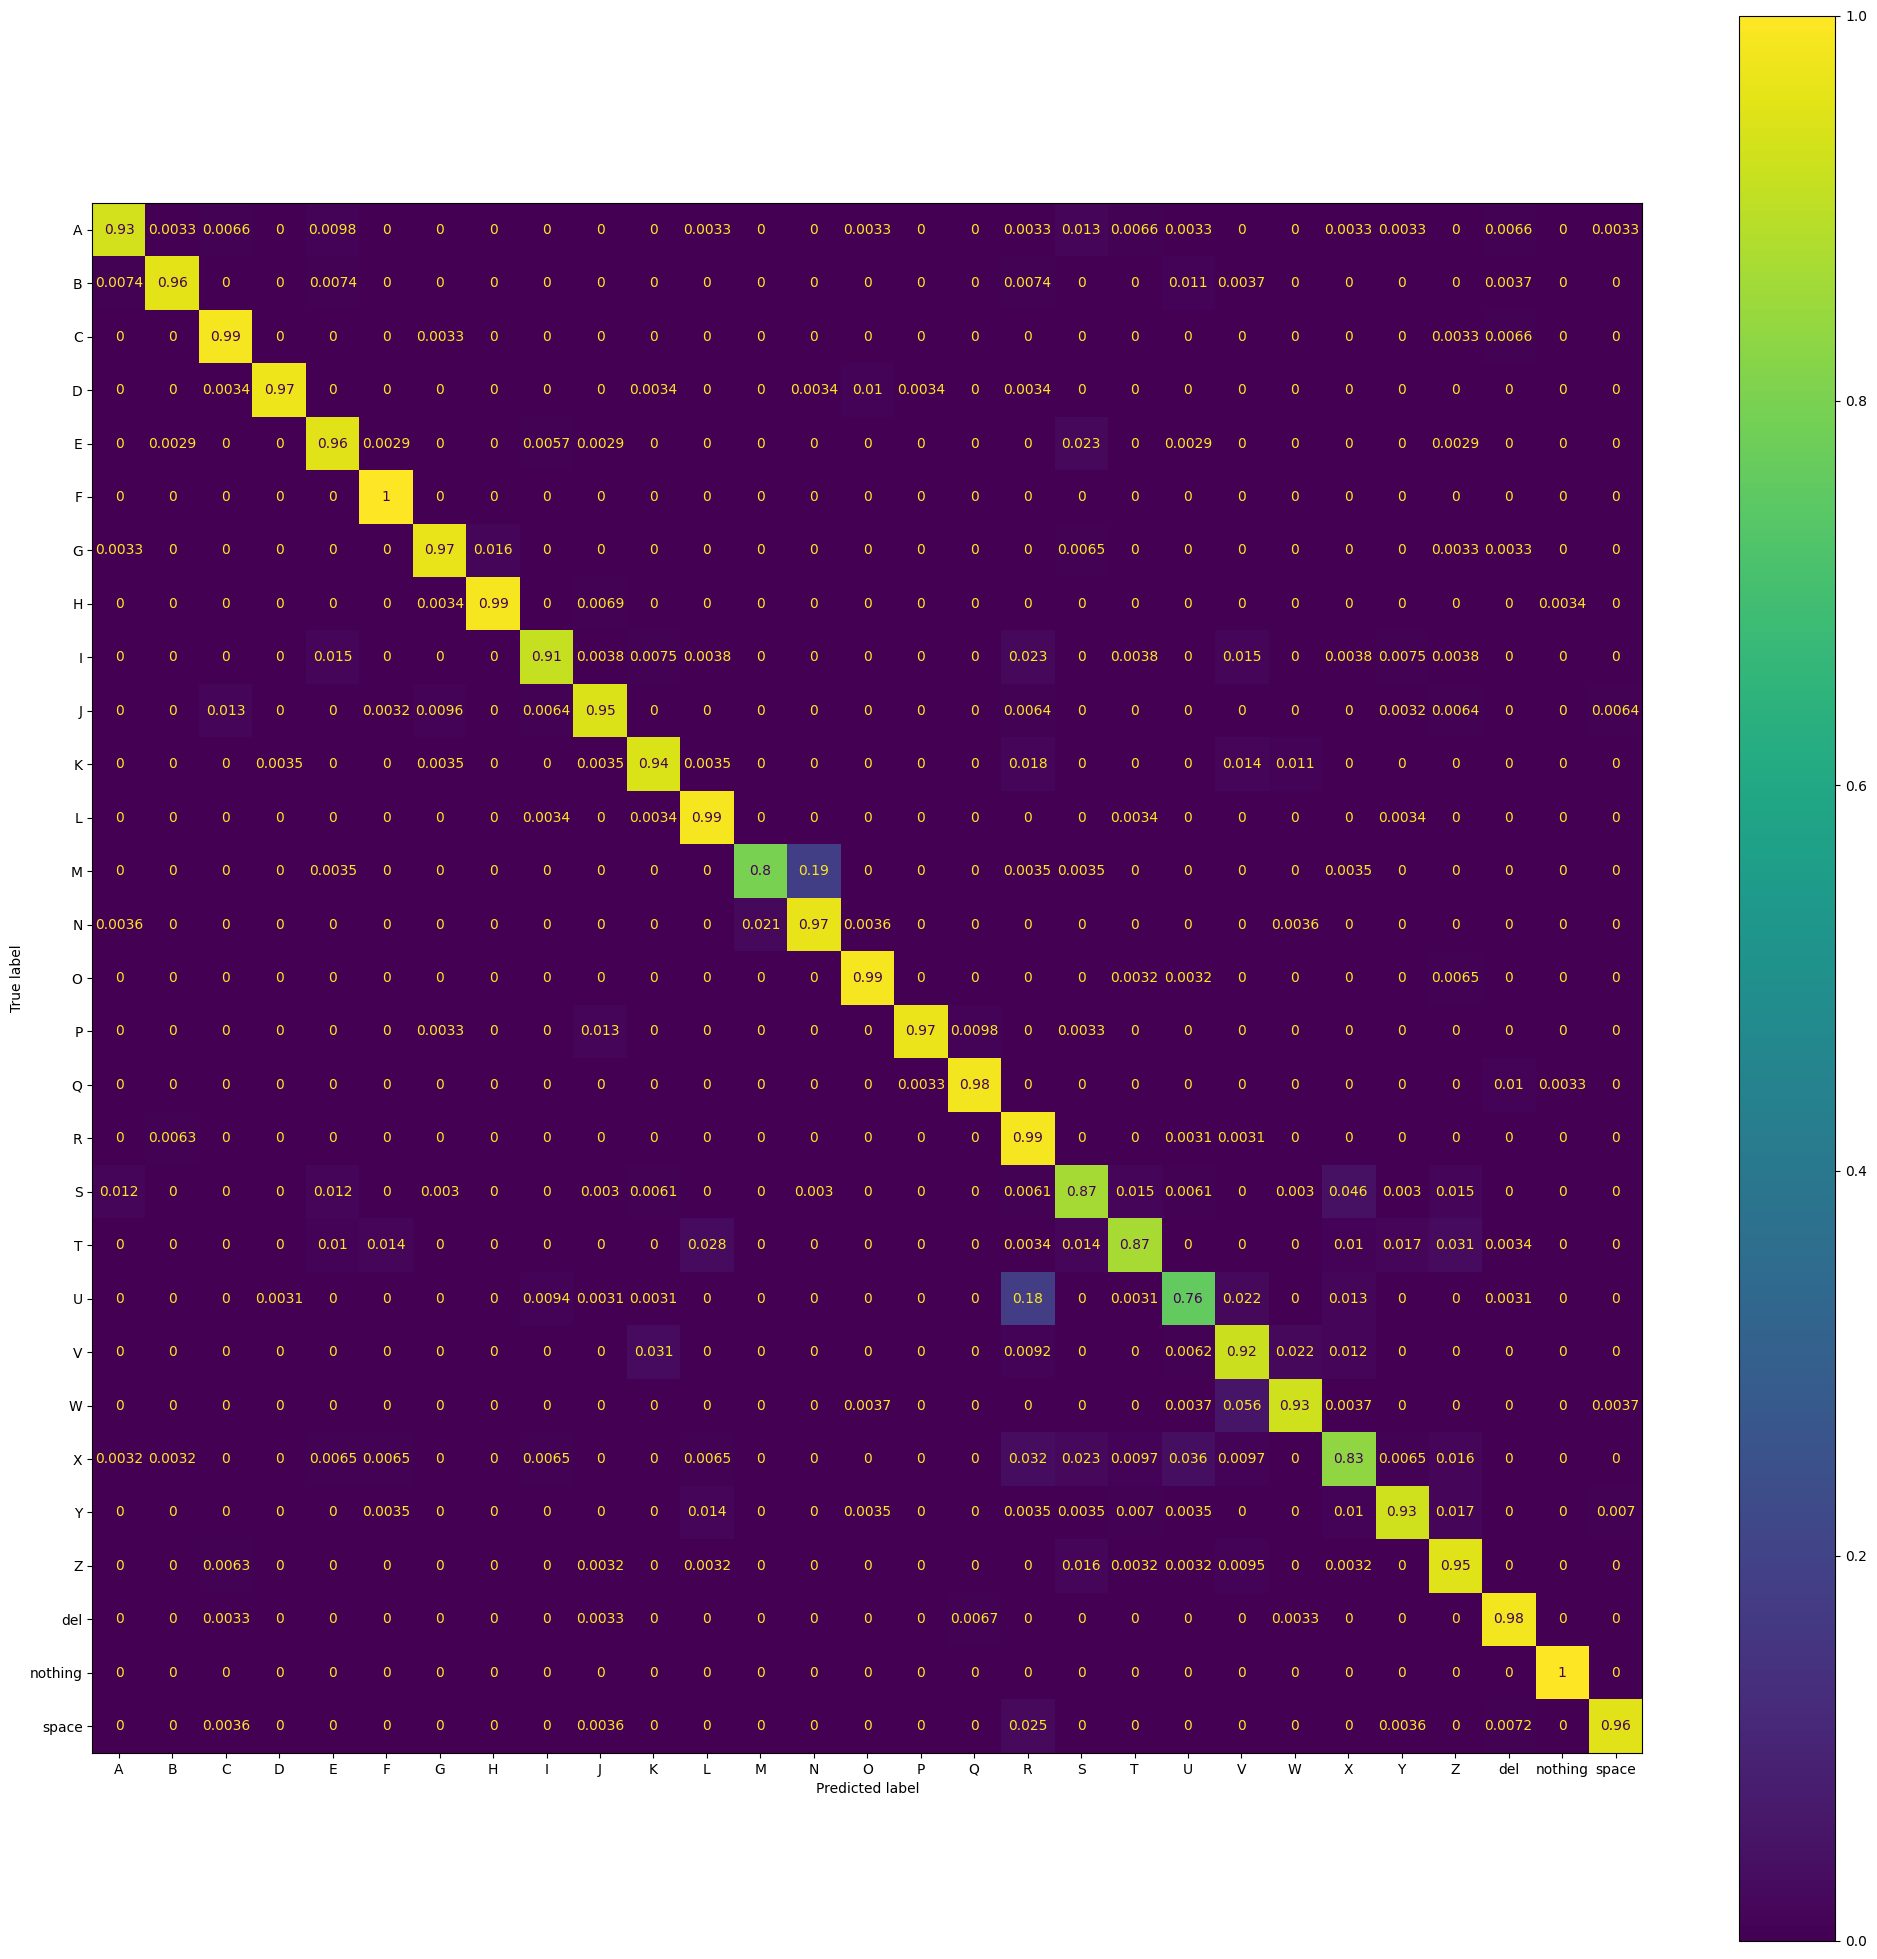

In [36]:
save_cfm_plot(model_name, results)

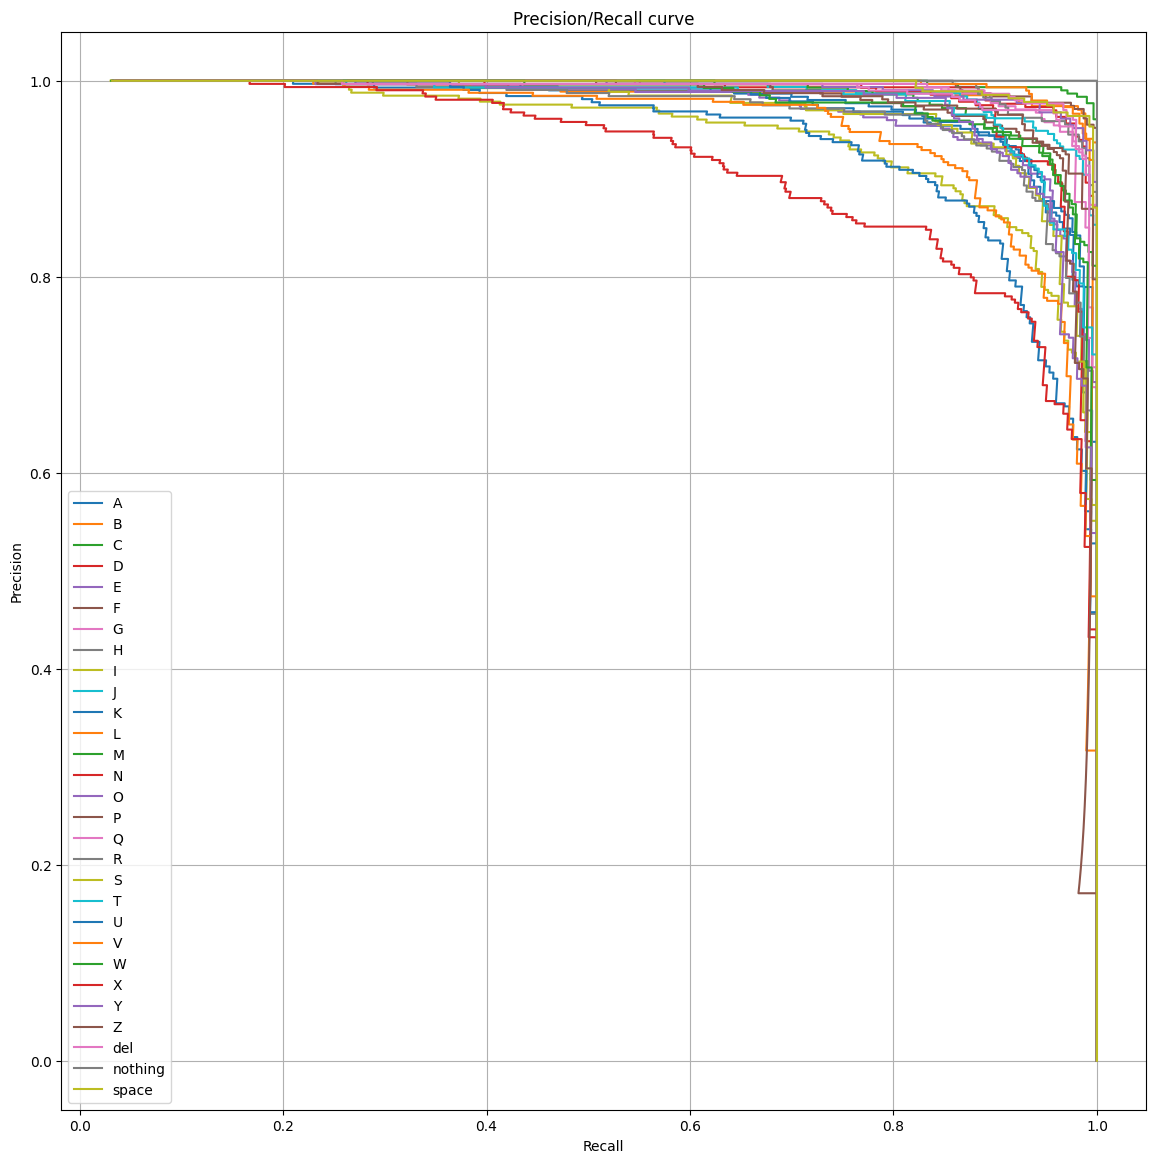

In [21]:
save_pr_curve_plot(model_name, results)

# Fine Tuning


### ResNeXt50 finetuning setup


In [25]:
## Setup Resnext50
model_name = "resnext_adam"
print(f"Model name: {model_name}")
model, model_fc = load_resnext50_model()
finetuneable_layers = [model.layer3, model.layer4]

## Setup layers for training
for param in model.parameters():
    param.requires_grad = False

# Open up fc layer for training
model.fc.requires_grad = True

# Open convulational layers for training
for layer in finetuneable_layers:
    for param in layer.parameters():
        param.requires_grad = True

save_model_name = "resnet_adam_finetune_augment"


norm_dataloaders, class_names, batch_size, dataset_sizes = gen_dataloaders(batch_size=64)

Model name: resnext_adam
Total number of trainable parameters: 23039325
Dataset sizes: {'train': 69600, 'val': 8700, 'test': 8700}
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


### Setup MobilenetV2


In [14]:
## Setup MobileNet
load_model_name = "mobilenet_adam"
print(f"Load model name: {load_model_name}")
model, model_fc = load_mobilenet_model()

## Setup layers for training
for param in model.parameters():
    param.requires_grad = True

save_model_name = "mobilenet_adam_finetune_flip"

# Load data
flip_dataloaders, class_names, batch_size, dataset_sizes = gen_dataloaders(
    normalize=True,
    batch_size=16,
    add_transforms=[transforms.RandomHorizontalFlip(p=0.5)],
)

Load model name: mobilenet_adam


### Load best model params


In [15]:
model_path = f"{load_model_name}/best_model_params.pt"
result = model.load_state_dict(torch.load(model_path))

## Fine tuning / Training


In [18]:
## Set training mode
model.train()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_fc.parameters(), lr=2e-6, weight_decay=1e-4)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.01)

finetuned_model, history_ft = train_model(
    model,
    flip_dataloaders,
    criterion,
    optimizer,
    scheduler,
    num_epochs=4,
    save_dir=save_model_name,
)

Epoch 1/4
----------
Learning rate: [2e-06]


100%|██████████| 4350/4350 [08:14<00:00,  8.79it/s]


train Loss: 0.4157 Acc: 0.8884


100%|██████████| 544/544 [00:18<00:00, 29.11it/s]


val Loss: 0.2610 Acc: 0.9416
Found new best accuracy! Saving best model to mobilenet_adam_finetune_flip/best_model_params.pt...

Epoch 2/4
----------
Learning rate: [2e-06]


100%|██████████| 4350/4350 [08:16<00:00,  8.77it/s]


train Loss: 0.4120 Acc: 0.8904


100%|██████████| 544/544 [00:18<00:00, 29.62it/s]


val Loss: 0.2577 Acc: 0.9453
Found new best accuracy! Saving best model to mobilenet_adam_finetune_flip/best_model_params.pt...

Epoch 3/4
----------
Learning rate: [2e-06]


100%|██████████| 4350/4350 [08:14<00:00,  8.80it/s]


train Loss: 0.4101 Acc: 0.8912


100%|██████████| 544/544 [00:18<00:00, 29.58it/s]


val Loss: 0.2592 Acc: 0.9406

Epoch 4/4
----------
Learning rate: [2e-06]


100%|██████████| 4350/4350 [08:16<00:00,  8.77it/s]


train Loss: 0.4083 Acc: 0.8913


100%|██████████| 544/544 [00:18<00:00, 29.62it/s]

val Loss: 0.2612 Acc: 0.9428

Training complete in 34m 15s
Best accuracy: 0.945287356321839


### LR finder

In [ ]:
!pip install -q torch-lr-finder -v --global-option="apex"

In [ ]:
from torch_lr_finder import LRFinder
torch.cuda.empty_cache()
dataloaders, class_names, batch_size, dataset_sizes = gen_dataloaders(batch_size=16)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

# Receptive field analysis

Rasmus <3

Check whether neurons are blank to argue whether or not ResNeXt is too overkill. Can argue for modifying ResNeXt or choosing a more light weight model.


# Plot loss over epochs

Mamus <3

Gather information for learning rate in fine tuning.
See Howard


In [74]:
def show_history(history):
    plt.figure(figsize=(20, 6))

    # # summarize history for accuracy
    plt.subplot(121)
    plt.plot(history["accuracy"])
    plt.plot(history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "val"], loc="upper left")

    # summarize history for loss
    plt.subplot(122)
    plt.plot(history["loss"])
    plt.plot(history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "val"], loc="upper left")
    plt.show()

Model name: mobilenet_adam
{'loss': [0.8636696748349858, 0.5751377907018552, 0.44772815800261223, 0.376785655939716, 0.32477902520662066, 0.29079037581367057, 0.26569048038159293, 0.2511641413315959, 0.24840833534454476, 0.24725304904340328, 0.2450855096386767, 0.24205412972932575, 0.2403363086574379, 0.2389662943283717, 0.23641079103124552, 0.23735993893667198, 0.23732985404716142, 0.23666142826107728, 0.23581619224329103, 0.2373671628757455, 0.23704352269912587, 0.23657058261591812, 0.2370145560886668, 0.23593967952947506, 0.23814024195588868], 'accuracy': [0.8645402298850574, 0.9000718390804597, 0.9170114942528735, 0.9270402298850574, 0.9340804597701149, 0.9392672413793103, 0.9417528735632184, 0.9454597701149425, 0.9460344827586207, 0.9467385057471264, 0.9455028735632184, 0.9471551724137931, 0.9467097701149425, 0.9466954022988505, 0.9485488505747126, 0.9466091954022988, 0.9471120689655173, 0.947456896551724, 0.9479310344827586, 0.9470545977011494, 0.946580459770115, 0.94716954022988

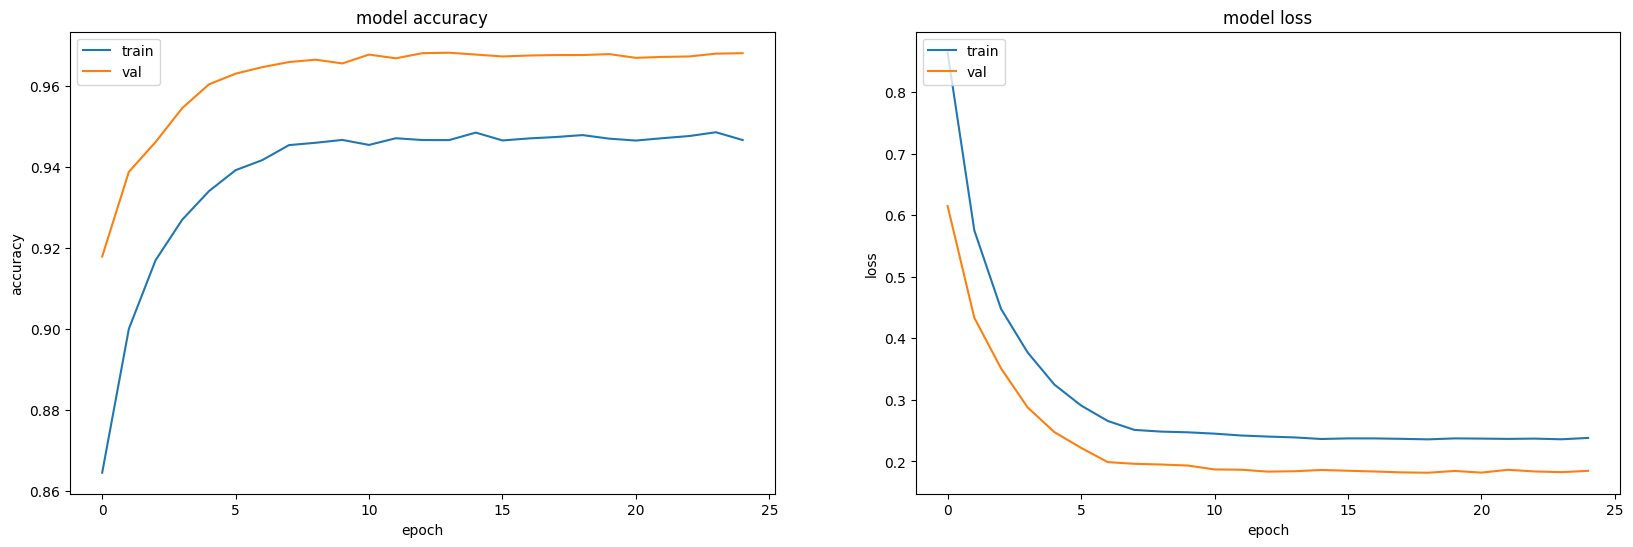

In [81]:
# Load history file
model_name = "mobilenet_adam"
print(f"Model name: {model_name}")
history = torch.load(f"{model_name}/model_history.pt")
print(history)
show_history(history)

# Class Activation Maps


In [26]:
def get_sample_of_class(dataloader, class_name: str, image_index=0):
    class_index = class_names.index(class_name.upper())
    i = 0
    for image, label in dataloader.dataset:
        if label == class_index:
            if i == image_index:
                return torch.unsqueeze(image, dim=0), label
            i += 1

## Heat maps

In [11]:
!pip install -q torchcam

In [24]:
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
from torchvision.models import MobileNetV2


def plot_image_heatmap(
    figure: plt.figure,
    model: MobileNetV2,
    norm_image,
    original_image,
    get_model_features,
):
    layer = get_model_features(model)
    cam_extractor = SmoothGradCAMpp(model, layer)

    model.eval()

    # Preprocess your data and feed it to the model
    out = model(norm_image.to(device))
    # Retrieve the CAM by passing the class index and the model output
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

    result = overlay_mask(
        to_pil_image(original_image.squeeze(0)),
        to_pil_image(activation_map[0].squeeze(0), mode="F"),
        alpha=0.5,
    )

    figure.imshow(result)


# Take a list of model names and create a heatmap for each model
def models_heatmap(
    title,
    model_names,
    model_labels,
    class_names: list[str],
    get_model_features,
    image_index=0,
):
    fig, axs = plt.subplots(
        len(model_names) + 1,
        len(class_names),
        constrained_layout=True,
        sharey=True,
        tight_layout=True,
        figsize=(10, 10),
    )

    fig.suptitle(title)

    for ax in axs.flat:
        ax.set(xticks=[], yticks=[])

    for col, class_name in enumerate(class_names):
        norm_dataloaders, class_names, batch_size, dataset_sizes = gen_dataloaders()
        unnorm_dataloaders, class_names, batch_size, dataset_sizes = gen_dataloaders(
            normalize=False
        )
        image, label = get_sample_of_class(
            norm_dataloaders["val"], class_name, image_index
        )
        original_image, label = get_sample_of_class(
            unnorm_dataloaders["val"], class_name, image_index
        )

        axs[0, col].set_title(class_name)
        axs[0, col].imshow(to_pil_image(original_image.squeeze(0)))

        for row, model_name in enumerate(model_names):
            model_path = f"{model_name}/best_model_params.pt"
            model.load_state_dict(torch.load(model_path))

            plot_image_heatmap(
                axs[row + 1, col],
                model,
                image,
                original_image,
                get_model_features,
            )

            axs[row + 1, col].set_ylabel(
                model_labels[row], rotation="horizontal", ha="right"
            )

    fig.show()

### ResNeXt50

In [41]:
from torchvision.models import ResNet
import random

# Heat maps for resnext50
model, model_fc = load_resnext50_model()

for p in model.layer3.parameters():
    p.requires_grad = True

def get_model_features(model: ResNet):
    return model.layer4[-1]


model_names = ["resnext_v2", "resnext_adam", "resnext_adam_finetune"]
random_index = random.randint(0, 10)
models_heatmap(model_names, "X", get_model_features, random_index)

NameError: name 'load_resnext50_model' is not defined

### MobileNetV2

Total number of trainable parameters: 2261021


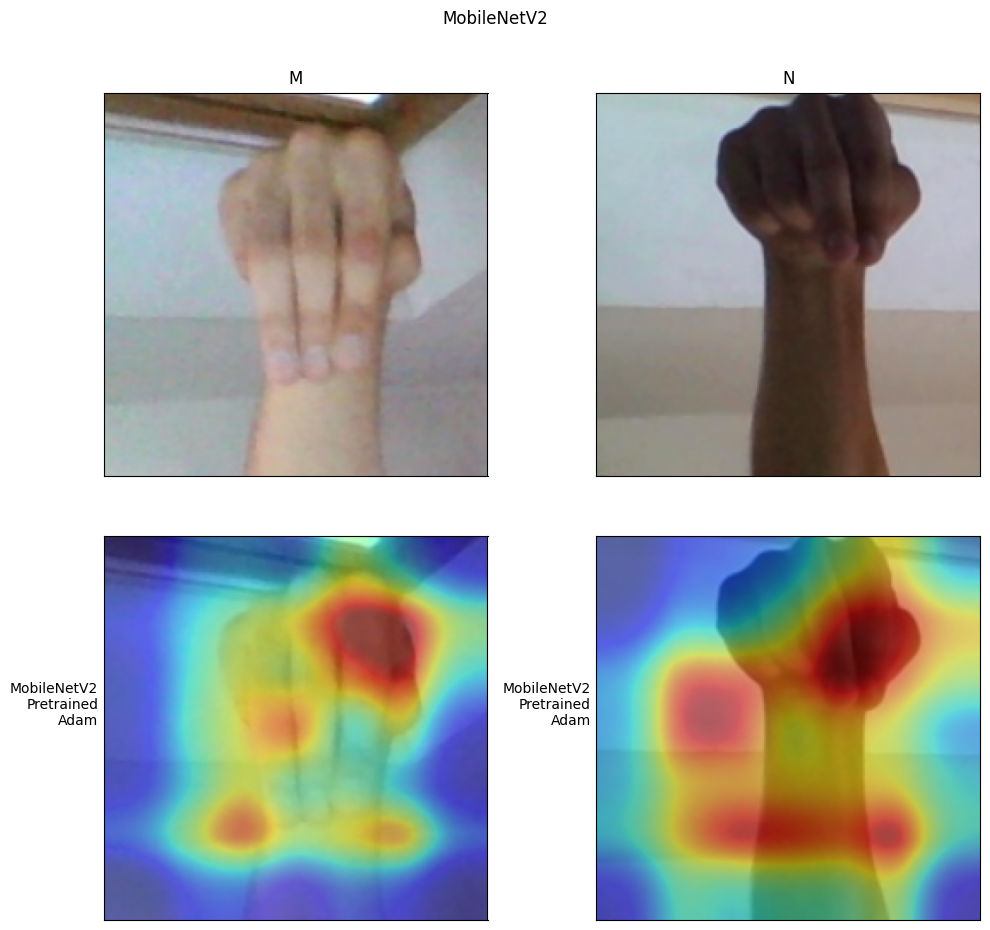

In [27]:
from torchvision.models import MobileNetV2
import random
# Heat maps for mobilenet

model, model_fc = load_mobilenet_model()

def get_model_features(model: MobileNetV2):
    return model.features[18]


model_names = [
    "mobilenet_adam",
    # "mobilenet_adam_finetune_lrfinder",
    # "mobilenet_adam_finetune_augment",
]

model_labels = [
    "MobileNetV2\nPretrained\nAdam",
]

random_index = random.randint(0, 10)
models_heatmap(
    "MobileNetV2",
    model_names,
    model_labels,
    ["M", "N"],
    get_model_features,
    random_index,
)

## Guided Backpropagation

In [77]:
from torchvision.models import MobileNetV2
import numpy as np


def relu_hook_function(module, grad_in, grad_out):
    if isinstance(module, torch.nn.ReLU):
        return (torch.clamp(grad_in[0], min=0.0),)


def set_model_backward_hook(model: MobileNetV2):
    for i, module in enumerate(model.modules()):
        if isinstance(module, torch.nn.ReLU):
            print(model.named_modules())
            module.register_backward_hook(relu_hook_function)


def prep_output(img_tensor):
    invTrans = torchvision.transforms.Compose(
        [
            torchvision.transforms.Normalize(
                mean=[0.0, 0.0, 0.0], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
            ),
            torchvision.transforms.Normalize(
                mean=[-0.485, -0.456, -0.406], std=[1.0, 1.0, 1.0]
            ),
        ]
    )
    out = invTrans(img_tensor)[0]
    out = out.detach().numpy().transpose(1, 2, 0)

    return out


def norm_flat_image(img):
    grads_norm = prep_output(img)
    grads_norm = grads_norm[:, :, 0] + grads_norm[:, :, 1] + grads_norm[:, :, 2]

    grads_norm = (grads_norm - np.min(grads_norm)) / (
        np.max(grads_norm) - np.min(grads_norm)
    )
    return grads_norm


def get_guided_backpropagation_grads(class_name, image, model: MobileNetV2):
    model.eval()
    image.requires_grad = True
    output = model(image.to(device))
    output[0, class_names.index(class_name)].backward()

    return image.grad

In [88]:
def plot_guided_backprop(model, norm_image, class_name, figure: plt.Figure):
    set_model_backward_hook(model)
    image_grads = get_guided_backpropagation_grads(class_name, norm_image, model)

    figure.imshow(norm_flat_image(image_grads), vmin=0.3, vmax=0.7, cmap="gray")

### All activation maps for a letter


Total number of trainable parameters: 2261021


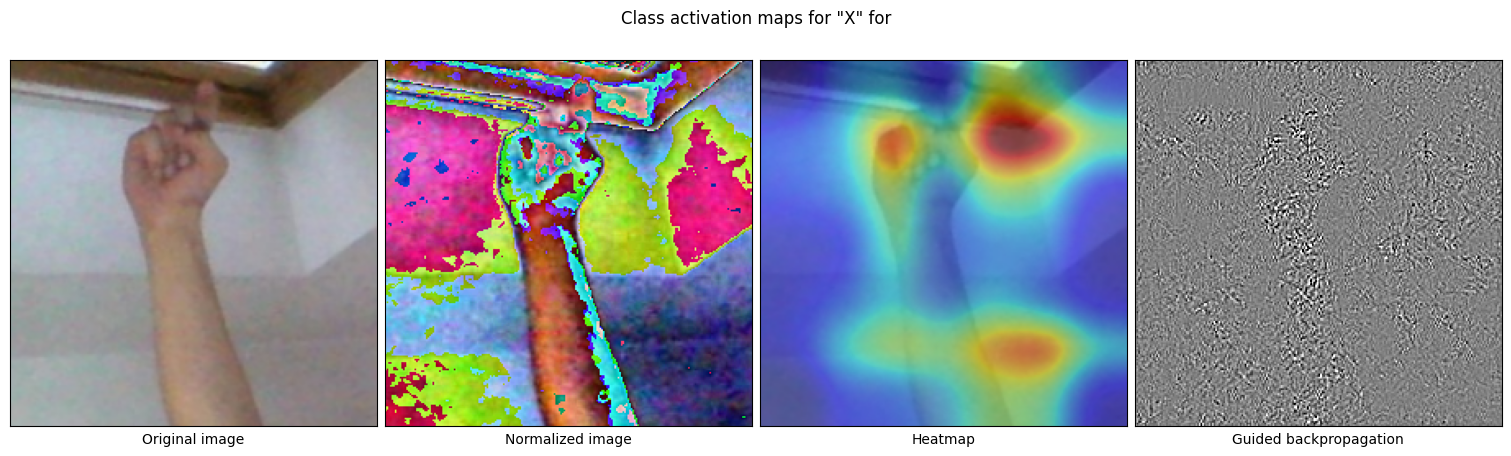

In [107]:
import random

class_name = "X"
image_index = random.randint(0, 10)
model_name = "mobilenet_adam"

model, model_fc = load_mobilenet_model()
model.load_state_dict(torch.load(f"{model_name}/best_model_params.pt"))


def get_model_features(model: MobileNetV2):
    return model.features[18]


figure, axs = plt.subplots(1, 4, constrained_layout=True, figsize=(15, 4.5))
for ax in axs.flat:
    ax.set(xticks=[], yticks=[])
figure.suptitle(f'Class activation maps for "{class_name}" for')

norm_dataloaders, class_names, batch_size, dataset_sizes = gen_dataloaders()
unnorm_dataloaders, class_names, batch_size, dataset_sizes = gen_dataloaders(
    normalize=False
)

norm_image, label = get_sample_of_class(
    norm_dataloaders["test"], class_name, image_index
)
original_image, label = get_sample_of_class(
    unnorm_dataloaders["test"], class_name, image_index
)

# Plot original image
axs[0].set_xlabel("Original image")
axs[0].imshow(to_pil_image(original_image.squeeze(0)))

# Plot normalized image
axs[1].set_xlabel("Normalized image")
axs[1].imshow(to_pil_image(norm_image.squeeze(0)))

# Plot heatmap
plot_image_heatmap(
    axs[2],
    model,
    norm_image,
    original_image,
    get_model_features,
)
axs[2].set_xlabel("Heatmap")

# Plot guided backpropagation
plot_guided_backprop(model, norm_image, class_name, axs[3])
axs[3].set_xlabel("Guided backpropagation")

figure.show()

## Data augmentation

Use albumentation to augment data


In [ ]:
!pip install -U albumentations

In [ ]:


# Declare an augmentation pipeline

norm_dataloaders, class_names, batch_size, dataset_sizes = gen_dataloaders()
image = norm_dataloaders["train"].dataset[0][0]
print(image.shape)

# Display an image
imshow(image)

# Plots

## Data set showcase

In [ ]:
dataloaders, class_names, batch_size, dataset_sizes = gen_dataloaders(normalize=False)